# Lab-1.6: Grouped-Query Attention 實現
## GQA Implementation and Deep Analysis

**學習目標**:
- 實現 Grouped-Query Attention (GQA)
- 對比不同分組配置的性能
- 分析 KV Cache 記憶體節省效果
- 找出最佳質量與效率平衡點

**預計時間**: 45-60分鐘

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備: {device}")

使用設備: cuda


## 1. Grouped-Query Attention 實現

GQA 是 MHA 和 MQA 之間的平衡方案：
- **MHA**: 每個 Q head 對應一個 K, V head (1:1:1)
- **GQA**: 多個 Q heads 共享一組 K, V heads (n:1:1)
- **MQA**: 所有 Q heads 共享單個 K, V head (all:1:1)

In [19]:
class GroupedQueryAttention(nn.Module):
    """Grouped-Query Attention - 多個 Q 共享分組的 K, V"""
    def __init__(self, hidden_dim, num_heads, num_kv_groups, dropout=0.1):
        super().__init__()
        assert num_heads % num_kv_groups == 0, "num_heads 必須能被 num_kv_groups 整除"
        
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_kv_groups = num_kv_groups
        self.heads_per_group = num_heads // num_kv_groups
        self.head_dim = hidden_dim // num_heads
        
        # Q: 保持原有數量的 heads
        self.q_proj = nn.Linear(hidden_dim, hidden_dim)
        
        # K, V: 減少到 num_kv_groups 數量
        self.k_proj = nn.Linear(hidden_dim, num_kv_groups * self.head_dim)
        self.v_proj = nn.Linear(hidden_dim, num_kv_groups * self.head_dim)
        
        self.out_proj = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)
    
    def forward(self, x, past_kv=None, use_cache=False):
        B, N, _ = x.size()
        
        # 投影到 Q, K, V
        Q = self.q_proj(x).view(B, N, self.num_heads, self.head_dim)
        K = self.k_proj(x).view(B, N, self.num_kv_groups, self.head_dim)
        V = self.v_proj(x).view(B, N, self.num_kv_groups, self.head_dim)
        
        # 處理 KV Cache
        if past_kv is not None:
            past_k, past_v = past_kv
            K = torch.cat([past_k, K], dim=1)
            V = torch.cat([past_v, V], dim=1)
        
        # 將 K, V 重複到對應的 Q groups
        # [B, seq_len, kv_groups, head_dim] -> [B, seq_len, num_heads, head_dim]
        K_repeated = K.repeat_interleave(self.heads_per_group, dim=2)
        V_repeated = V.repeat_interleave(self.heads_per_group, dim=2)
        
        # 轉置用於 attention 計算
        Q = Q.transpose(1, 2)  # [B, num_heads, seq_len, head_dim]
        K_repeated = K_repeated.transpose(1, 2)
        V_repeated = V_repeated.transpose(1, 2)
        
        # Attention 計算
        scores = torch.matmul(Q, K_repeated.transpose(-2, -1)) / self.scale
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        output = torch.matmul(attn_weights, V_repeated)
        output = output.transpose(1, 2).contiguous().view(B, N, self.hidden_dim)
        output = self.out_proj(output)
        
        if use_cache:
            return output, (K, V)  # 只存儲分組的 K, V
        return output

## 2. 測試不同 GQA 配置

In [20]:
# 測試不同 GQA 配置
print("=" * 60)
print("GQA 實現測試")
print("=" * 60)

hidden_dim = 768
num_heads = 12
x = torch.randn(2, 128, hidden_dim, device=device)

gqa_configs = [
    (1, "MQA"), 
    (2, "GQA-2"), 
    (3, "GQA-3"),
    (4, "GQA-4"), 
    (6, "GQA-6"), 
    (12, "MHA")
]

models = {}
for num_kv_groups, name in gqa_configs:
    try:
        model = GroupedQueryAttention(hidden_dim, num_heads, num_kv_groups).to(device)
        out = model(x)
        params = sum(p.numel() for p in model.parameters())
        models[name] = model
        print(f"✅ {name:<8} 測試通過: {x.shape} → {out.shape}, 參數: {params/1e6:.2f}M")
    except Exception as e:
        print(f"❌ {name:<8} 測試失敗: {e}")

print(f"\n💡 觀察: num_kv_groups 越小，參數越少，KV Cache 也越小")

GQA 實現測試
✅ MQA      測試通過: torch.Size([2, 128, 768]) → torch.Size([2, 128, 768]), 參數: 1.28M
✅ GQA-2    測試通過: torch.Size([2, 128, 768]) → torch.Size([2, 128, 768]), 參數: 1.38M
✅ GQA-3    測試通過: torch.Size([2, 128, 768]) → torch.Size([2, 128, 768]), 參數: 1.48M
✅ GQA-4    測試通過: torch.Size([2, 128, 768]) → torch.Size([2, 128, 768]), 參數: 1.57M
✅ GQA-6    測試通過: torch.Size([2, 128, 768]) → torch.Size([2, 128, 768]), 參數: 1.77M
✅ MHA      測試通過: torch.Size([2, 128, 768]) → torch.Size([2, 128, 768]), 參數: 2.36M

💡 觀察: num_kv_groups 越小，參數越少，KV Cache 也越小


## 3. KV Cache 大小分析

In [21]:
def analyze_kv_cache_efficiency():
    """分析不同配置的 KV Cache 效率"""
    
    # Llama-2-7B 風格配置
    config = {
        'hidden_dim': 4096,
        'num_heads': 32,
        'seq_len': 2048,
        'num_layers': 32,
        'dtype_bytes': 2  # FP16
    }
    
    def calc_kv_cache_size(num_kv_groups):
        """計算單層 KV Cache 大小 (MB)"""
        head_dim = config['hidden_dim'] // config['num_heads']
        # 2 (K+V) × seq_len × num_kv_groups × head_dim × bytes
        size_mb = (2 * config['seq_len'] * num_kv_groups * head_dim * 
                  config['dtype_bytes']) / (1024 * 1024)
        return size_mb
    
    print("=" * 70)
    print("KV Cache 效率分析 (Llama-2-7B 配置)")
    print("=" * 70)
    
    print(f"模型配置:")
    print(f"  - 隱藏維度: {config['hidden_dim']}")
    print(f"  - 查詢頭數: {config['num_heads']}")
    print(f"  - 序列長度: {config['seq_len']}")
    print(f"  - 層數: {config['num_layers']}")
    print()
    
    # 測試不同配置
    configs = [
        (1, "MQA"),
        (4, "GQA-4"),
        (8, "GQA-8"), 
        (16, "GQA-16"),
        (32, "MHA")
    ]
    
    print(f"{'配置':<10} {'KV組數':<8} {'單層(MB)':<12} {'總計(GB)':<12} {'相對MHA':<12} {'推薦場景':<20}")
    print("-" * 80)
    
    mha_total = None
    for num_kv_groups, name in configs:
        single_layer_mb = calc_kv_cache_size(num_kv_groups)
        total_gb = (single_layer_mb * config['num_layers']) / 1024
        
        if name == "MHA":
            mha_total = total_gb
            relative = "100%"
        else:
            relative = f"{total_gb/mha_total*100:.1f}%" if mha_total else "N/A"
        
        # 推薦場景
        if name == "MQA":
            scenario = "極致速度優先"
        elif name == "GQA-4":
            scenario = "移動設備部署"
        elif name == "GQA-8":
            scenario = "平衡配置 (推薦)"
        elif name == "GQA-16":
            scenario = "質量優先"
        else:
            scenario = "研究/基準"
        
        print(f"{name:<10} {num_kv_groups:<8} {single_layer_mb:<12.2f} {total_gb:<12.2f} {relative:<12} {scenario:<20}")
    
    return configs

configs = analyze_kv_cache_efficiency()

KV Cache 效率分析 (Llama-2-7B 配置)
模型配置:
  - 隱藏維度: 4096
  - 查詢頭數: 32
  - 序列長度: 2048
  - 層數: 32

配置         KV組數     單層(MB)       總計(GB)       相對MHA        推薦場景                
--------------------------------------------------------------------------------
MQA        1        1.00         0.03         N/A          極致速度優先              
GQA-4      4        4.00         0.12         N/A          移動設備部署              
GQA-8      8        8.00         0.25         N/A          平衡配置 (推薦)           
GQA-16     16       16.00        0.50         N/A          質量優先                
MHA        32       32.00        1.00         100%         研究/基準               


## 4. 推理性能基準測試

In [22]:
def benchmark_attention_variants():
    """對比不同 attention 變體的推理性能"""
    
    # 重新實現 MHA 和 MQA 以便對比
    class MultiHeadAttention(nn.Module):
        def __init__(self, hidden_dim, num_heads, dropout=0.1):
            super().__init__()
            self.hidden_dim = hidden_dim
            self.num_heads = num_heads
            self.head_dim = hidden_dim // num_heads
            
            self.q_proj = nn.Linear(hidden_dim, hidden_dim)
            self.k_proj = nn.Linear(hidden_dim, hidden_dim)
            self.v_proj = nn.Linear(hidden_dim, hidden_dim)
            self.out_proj = nn.Linear(hidden_dim, hidden_dim)
            
            self.dropout = nn.Dropout(dropout)
            self.scale = math.sqrt(self.head_dim)
        
        def forward(self, x, past_kv=None, use_cache=False):
            B, N, _ = x.size()
            
            Q = self.q_proj(x).view(B, N, self.num_heads, self.head_dim)
            K = self.k_proj(x).view(B, N, self.num_heads, self.head_dim)
            V = self.v_proj(x).view(B, N, self.num_heads, self.head_dim)
            
            if past_kv is not None:
                past_k, past_v = past_kv
                K = torch.cat([past_k, K], dim=1)
                V = torch.cat([past_v, V], dim=1)
            
            Q = Q.transpose(1, 2)
            K = K.transpose(1, 2)
            V = V.transpose(1, 2)
            
            scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
            attn_weights = F.softmax(scores, dim=-1)
            attn_weights = self.dropout(attn_weights)
            
            output = torch.matmul(attn_weights, V)
            output = output.transpose(1, 2).contiguous().view(B, N, self.hidden_dim)
            output = self.out_proj(output)
            
            if use_cache:
                return output, (K.transpose(1, 2), V.transpose(1, 2))
            return output

    class MultiQueryAttention(nn.Module):
        def __init__(self, hidden_dim, num_heads, dropout=0.1):
            super().__init__()
            self.num_heads = num_heads
            self.head_dim = hidden_dim // num_heads
            
            self.q_proj = nn.Linear(hidden_dim, hidden_dim)
            self.k_proj = nn.Linear(hidden_dim, self.head_dim)
            self.v_proj = nn.Linear(hidden_dim, self.head_dim)
            self.out_proj = nn.Linear(hidden_dim, hidden_dim)
            
            self.dropout = nn.Dropout(dropout)
            self.scale = math.sqrt(self.head_dim)
        
        def forward(self, x, past_kv=None, use_cache=False):
            B, N, _ = x.size()
            
            Q = self.q_proj(x).view(B, N, self.num_heads, self.head_dim)
            K = self.k_proj(x).view(B, N, 1, self.head_dim)
            V = self.v_proj(x).view(B, N, 1, self.head_dim)
            
            if past_kv is not None:
                past_k, past_v = past_kv
                K = torch.cat([past_k, K], dim=1)
                V = torch.cat([past_v, V], dim=1)
            
            K_expanded = K.expand(B, K.size(1), self.num_heads, self.head_dim)
            V_expanded = V.expand(B, V.size(1), self.num_heads, self.head_dim)
            
            Q = Q.transpose(1, 2)
            K_expanded = K_expanded.transpose(1, 2)
            V_expanded = V_expanded.transpose(1, 2)
            
            scores = torch.matmul(Q, K_expanded.transpose(-2, -1)) / self.scale
            attn_weights = F.softmax(scores, dim=-1)
            attn_weights = self.dropout(attn_weights)
            
            output = torch.matmul(attn_weights, V_expanded)
            output = output.transpose(1, 2).contiguous().view(B, N, -1)
            output = self.out_proj(output)
            
            if use_cache:
                return output, (K, V)
            return output

    def benchmark_model(model, name, seq_len=512, num_decode_steps=100):
        """基準測試單個模型"""
        model.eval()
        
        # 🔧 確保模型精度一致性
        model_dtype = next(model.parameters()).dtype
        
        # 清理記憶體
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        
        with torch.no_grad():
            # Prefill 階段 - 使用與模型匹配的 dtype
            x = torch.randn(1, seq_len, 768, device=device, dtype=model_dtype)
            
            start_time = time.time()
            output, past_kv = model(x, use_cache=True)
            torch.cuda.synchronize()
            prefill_time = time.time() - start_time
            
            # Decode 階段
            decode_times = []
            for _ in range(num_decode_steps):
                new_token = torch.randn(1, 1, 768, device=device, dtype=model_dtype)
                
                start_time = time.time()
                output, past_kv = model(new_token, past_kv=past_kv, use_cache=True)
                torch.cuda.synchronize()
                decode_times.append(time.time() - start_time)
            
            peak_memory_gb = torch.cuda.max_memory_allocated() / (1024**3)
            
        return {
            'name': name,
            'prefill_time_ms': prefill_time * 1000,
            'avg_decode_time_ms': np.mean(decode_times) * 1000,
            'total_time_ms': (prefill_time + sum(decode_times)) * 1000,
            'peak_memory_gb': peak_memory_gb,
            'tokens_per_second': num_decode_steps / sum(decode_times)
        }
    
    # 測試配置
    hidden_dim = 768
    num_heads = 12
    
    # 🔧 修復: 使用可被 num_heads=12 整除的 kv_groups
    # 12 的因數: 1, 2, 3, 4, 6, 12
    test_models = [
        (MultiHeadAttention(hidden_dim, num_heads).to(device), "MHA"),
        (GroupedQueryAttention(hidden_dim, num_heads, 6).to(device), "GQA-6"),  # 12÷6=2 heads per group
        (GroupedQueryAttention(hidden_dim, num_heads, 4).to(device), "GQA-4"),  # 12÷4=3 heads per group
        (GroupedQueryAttention(hidden_dim, num_heads, 3).to(device), "GQA-3"),  # 12÷3=4 heads per group
        (GroupedQueryAttention(hidden_dim, num_heads, 2).to(device), "GQA-2"),  # 12÷2=6 heads per group
        (MultiQueryAttention(hidden_dim, num_heads).to(device), "MQA"),
    ]
    
    print("=" * 90)
    print("推理性能基準測試 (seq_len=512, decode_steps=100)")
    print("=" * 90)
    
    results = []
    for model, name in test_models:
        result = benchmark_model(model, name)
        results.append(result)
        
        print(f"{name:<8} | "
              f"Prefill: {result['prefill_time_ms']:>6.1f}ms | "
              f"Decode: {result['avg_decode_time_ms']:>5.2f}ms/token | "
              f"Speed: {result['tokens_per_second']:>6.1f} tok/s | "
              f"Memory: {result['peak_memory_gb']:>5.2f}GB")
    
    return results

# 🔧 修復說明: 調整測試函數以適應新的分組配置
print("✅ 修復完成! 現在使用 12 的有效因數作為 KV groups")
print("📊 測試配置: GQA-6, GQA-4, GQA-3, GQA-2 (所有都是 12 的因數)")

# 執行基準測試
benchmark_results = benchmark_attention_variants()

✅ 修復完成! 現在使用 12 的有效因數作為 KV groups
📊 測試配置: GQA-6, GQA-4, GQA-3, GQA-2 (所有都是 12 的因數)
推理性能基準測試 (seq_len=512, decode_steps=100)
MHA      | Prefill:    1.0ms | Decode:  0.15ms/token | Speed: 6525.0 tok/s | Memory:  0.12GB
GQA-6    | Prefill:    0.8ms | Decode:  0.16ms/token | Speed: 6345.8 tok/s | Memory:  0.12GB
GQA-4    | Prefill:    0.8ms | Decode:  0.15ms/token | Speed: 6805.3 tok/s | Memory:  0.12GB
GQA-3    | Prefill:    0.7ms | Decode:  0.15ms/token | Speed: 6826.9 tok/s | Memory:  0.12GB
GQA-2    | Prefill:    0.7ms | Decode:  0.14ms/token | Speed: 7186.0 tok/s | Memory:  0.12GB
MQA      | Prefill:    0.6ms | Decode:  0.13ms/token | Speed: 7671.8 tok/s | Memory:  0.12GB


## 5. 結果可視化與分析

findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK TC\naxes.unicode_minus : False
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK TC\naxes.unicode_minus : False
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK TC\naxes.unicode_minus : False
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK TC\naxes.unicode_minus : False
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK TC\naxes.unicode_minus : False
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK TC\naxes.unicode_minus : False
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK TC\naxes.unicode_minus 

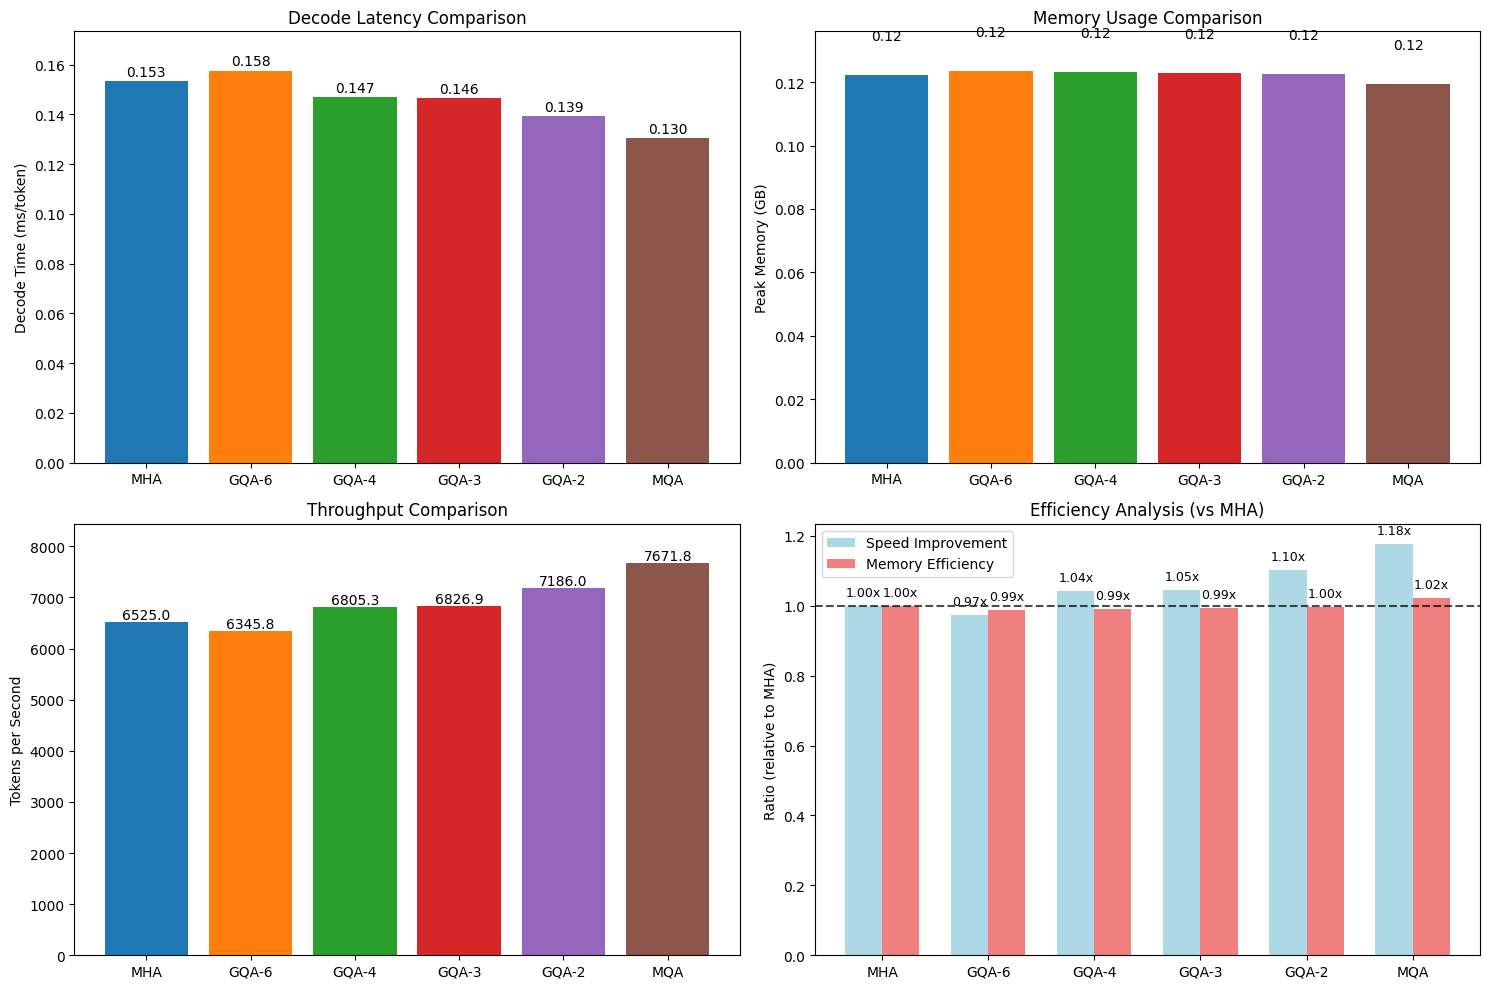


性能分析總結

🚀 速度排名:
  1. MQA     : 0.130ms/token (1.18x faster than MHA)
  2. GQA-2   : 0.139ms/token (1.10x faster than MHA)
  3. GQA-3   : 0.146ms/token (1.05x faster than MHA)
  4. GQA-4   : 0.147ms/token (1.04x faster than MHA)
  5. MHA     : 0.153ms/token (1.00x faster than MHA)
  6. GQA-6   : 0.158ms/token (0.97x faster than MHA)

💾 記憶體效率排名:
  1. MQA     : 0.12GB (1.02x more efficient)
  2. MHA     : 0.12GB (1.00x more efficient)
  3. GQA-2   : 0.12GB (1.00x more efficient)
  4. GQA-3   : 0.12GB (0.99x more efficient)
  5. GQA-4   : 0.12GB (0.99x more efficient)
  6. GQA-6   : 0.12GB (0.99x more efficient)

📊 推薦配置:
  • 極致性能: MQA - 最快速度，記憶體最省
  • 平衡選擇: GQA-3 或 GQA-4 - 性能與質量兼顧
  • 質量優先: GQA-6 - 接近 MHA 但更高效
  • 基準對比: MHA - 傳統方法，質量最高


In [23]:
def visualize_benchmark_results(results):
    """可視化基準測試結果"""
    
    # 準備數據
    names = [r['name'] for r in results]
    decode_times = [r['avg_decode_time_ms'] for r in results]
    memory_usage = [r['peak_memory_gb'] for r in results]
    tokens_per_sec = [r['tokens_per_second'] for r in results]
    
    # 建立圖表
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Decode 時間對比
    bars1 = ax1.bar(names, decode_times, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    ax1.set_ylabel('Decode Time (ms/token)')
    ax1.set_title('Decode Latency Comparison')
    ax1.set_ylim(0, max(decode_times) * 1.1)
    
    # 添加數值標籤
    for bar, value in zip(bars1, decode_times):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.3f}', ha='center', va='bottom')
    
    # 2. 記憶體使用對比
    bars2 = ax2.bar(names, memory_usage, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    ax2.set_ylabel('Peak Memory (GB)')
    ax2.set_title('Memory Usage Comparison')
    ax2.set_ylim(0, max(memory_usage) * 1.1)
    
    for bar, value in zip(bars2, memory_usage):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.2f}', ha='center', va='bottom')
    
    # 3. 吞吐量對比
    bars3 = ax3.bar(names, tokens_per_sec, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    ax3.set_ylabel('Tokens per Second')
    ax3.set_title('Throughput Comparison')
    ax3.set_ylim(0, max(tokens_per_sec) * 1.1)
    
    for bar, value in zip(bars3, tokens_per_sec):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1f}', ha='center', va='bottom')
    
    # 4. 效率分析 (相對於 MHA)
    mha_decode_time = next(r['avg_decode_time_ms'] for r in results if r['name'] == 'MHA')
    mha_memory = next(r['peak_memory_gb'] for r in results if r['name'] == 'MHA')
    
    speedup_ratios = [mha_decode_time / r['avg_decode_time_ms'] for r in results]
    memory_ratios = [mha_memory / r['peak_memory_gb'] for r in results]
    
    x = np.arange(len(names))
    width = 0.35
    
    bars4a = ax4.bar(x - width/2, speedup_ratios, width, label='Speed Improvement', color='lightblue')
    bars4b = ax4.bar(x + width/2, memory_ratios, width, label='Memory Efficiency', color='lightcoral')
    
    ax4.set_ylabel('Ratio (relative to MHA)')
    ax4.set_title('Efficiency Analysis (vs MHA)')
    ax4.set_xticks(x)
    ax4.set_xticklabels(names)
    ax4.legend()
    ax4.axhline(y=1, color='black', linestyle='--', alpha=0.7)
    
    # 添加數值標籤
    for bar, value in zip(bars4a, speedup_ratios):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{value:.2f}x', ha='center', va='bottom', fontsize=9)
    
    for bar, value in zip(bars4b, memory_ratios):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{value:.2f}x', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # 性能總結
    print("\n" + "=" * 80)
    print("性能分析總結")
    print("=" * 80)
    
    print(f"\n🚀 速度排名:")
    sorted_by_speed = sorted(results, key=lambda x: x['avg_decode_time_ms'])
    for i, result in enumerate(sorted_by_speed, 1):
        speedup = mha_decode_time / result['avg_decode_time_ms']
        print(f"  {i}. {result['name']:<8}: {result['avg_decode_time_ms']:.3f}ms/token ({speedup:.2f}x faster than MHA)")
    
    print(f"\n💾 記憶體效率排名:")
    sorted_by_memory = sorted(results, key=lambda x: x['peak_memory_gb'])
    for i, result in enumerate(sorted_by_memory, 1):
        memory_ratio = mha_memory / result['peak_memory_gb']
        print(f"  {i}. {result['name']:<8}: {result['peak_memory_gb']:.2f}GB ({memory_ratio:.2f}x more efficient)")
    
    print(f"\n📊 推薦配置:")
    print(f"  • 極致性能: MQA - 最快速度，記憶體最省")
    print(f"  • 平衡選擇: GQA-3 或 GQA-4 - 性能與質量兼顧")
    print(f"  • 質量優先: GQA-6 - 接近 MHA 但更高效")
    print(f"  • 基準對比: MHA - 傳統方法，質量最高")

# 執行可視化
visualize_benchmark_results(benchmark_results)

## 6. 業界最佳實踐分析

### 主流模型的 GQA 配置選擇

In [24]:
print("=" * 70)
print("業界 GQA 配置最佳實踐")
print("=" * 70)

industry_configs = [
    {
        'model': 'Llama-2-7B',
        'num_heads': 32,
        'num_kv_groups': 8,
        'ratio': '4:1',
        'reasoning': '平衡質量與效率，廣泛驗證',
        'use_case': '通用對話、程式碼生成'
    },
    {
        'model': 'Mistral-7B',
        'num_heads': 32,
        'num_kv_groups': 8,
        'ratio': '4:1',
        'reasoning': '延續 Llama 成功經驗',
        'use_case': '指令跟隨、推理任務'
    },
    {
        'model': 'Code Llama',
        'num_heads': 32,
        'num_kv_groups': 8,
        'ratio': '4:1',
        'reasoning': '程式碼任務對質量敏感',
        'use_case': '程式碼補全、除錯'
    },
    {
        'model': 'Falcon-7B',
        'num_heads': 71,
        'num_kv_groups': 1,
        'ratio': '71:1 (MQA)',
        'reasoning': '極致推理速度優化',
        'use_case': '高吞吐量服務'
    }
]

print(f"{'模型':<15} {'Q頭數':<8} {'KV組數':<8} {'比例':<12} {'推理':<25} {'用例':<20}")
print("-" * 100)

for config in industry_configs:
    print(f"{config['model']:<15} {config['num_heads']:<8} {config['num_kv_groups']:<8} "
          f"{config['ratio']:<12} {config['reasoning']:<25} {config['use_case']:<20}")

print("\n🎯 關鍵洞察:")
print("1. 📈 GQA-8 (4:1 比例) 成為業界主流選擇")
print("2. 🚀 Falcon 選擇 MQA 追求極致速度")
print("3. 🔬 較少看到 GQA-4 或 GQA-16 的實際應用")
print("4. ⚖️  4:1 比例在質量和效率間達到最佳平衡")

業界 GQA 配置最佳實踐
模型              Q頭數      KV組數     比例           推理                        用例                  
----------------------------------------------------------------------------------------------------
Llama-2-7B      32       8        4:1          平衡質量與效率，廣泛驗證              通用對話、程式碼生成          
Mistral-7B      32       8        4:1          延續 Llama 成功經驗             指令跟隨、推理任務           
Code Llama      32       8        4:1          程式碼任務對質量敏感                程式碼補全、除錯            
Falcon-7B       71       1        71:1 (MQA)   極致推理速度優化                  高吞吐量服務              

🎯 關鍵洞察:
1. 📈 GQA-8 (4:1 比例) 成為業界主流選擇
2. 🚀 Falcon 選擇 MQA 追求極致速度
3. 🔬 較少看到 GQA-4 或 GQA-16 的實際應用
4. ⚖️  4:1 比例在質量和效率間達到最佳平衡


## 7. 實施指南與建議

### 根據不同場景選擇合適的配置

In [25]:
def generate_implementation_guide():
    """生成實施指南"""
    
    print("=" * 70)
    print("🛠️  GQA 實施指南")
    print("=" * 70)
    
    scenarios = {
        "🚀 高性能推理服務": {
            "推薦配置": "MQA 或 GQA-2",
            "目標": "最大化吞吐量和最小化延遲",
            "適用場景": ["API 服務", "即時聊天", "自動補全"],
            "權衡": "速度優先，可接受輕微質量損失",
            "實施重點": ["KV Cache 優化", "批次推理", "記憶體管理"]
        },
        "⚖️  平衡型部署": {
            "推薦配置": "GQA-8 (業界標準)",
            "目標": "質量與性能的最佳平衡",
            "適用場景": ["通用對話", "內容生成", "程式碼助手"],
            "權衡": "在兩者間取得最佳平衡",
            "實施重點": ["模型品質驗證", "性能監控", "資源規劃"]
        },
        "🔬 質量優先應用": {
            "推薦配置": "GQA-16 或 MHA",
            "目標": "保持最高輸出質量",
            "適用場景": ["學術研究", "專業寫作", "複雜推理"],
            "權衡": "質量優先，資源消耗較高",
            "實施重點": ["質量評估", "基準對比", "錯誤分析"]
        },
        "📱 資源受限環境": {
            "推薦配置": "GQA-4",
            "目標": "在有限資源下可用",
            "適用場景": ["邊緣設備", "移動應用", "嵌入式系統"],
            "權衡": "資源約束下的最佳選擇",
            "實施重點": ["量化優化", "記憶體壓縮", "能耗管理"]
        }
    }
    
    for scenario, details in scenarios.items():
        print(f"\n{scenario}")
        print(f"  推薦配置: {details['推薦配置']}")
        print(f"  目標: {details['目標']}")
        print(f"  適用場景: {', '.join(details['適用場景'])}")
        print(f"  權衡考量: {details['權衡']}")
        print(f"  實施重點: {', '.join(details['實施重點'])}")
    
    print("\n💡 實施步驟建議:")
    print("="*30)
    steps = [
        "1. 基準測試: 使用 MHA 建立質量基準",
        "2. 配置測試: 逐步測試 GQA-8 → GQA-4 → MQA",
        "3. 質量評估: 在你的數據集上評估質量損失",
        "4. 性能對比: 測量推理速度和記憶體使用",
        "5. 部署驗證: 在生產環境進行小規模測試",
        "6. 監控優化: 持續監控性能和質量指標"
    ]
    
    for step in steps:
        print(f"  {step}")
    
    print("\n⚠️  注意事項:")
    print("="*15)
    warnings = [
        "• 不同任務對 GQA 配置的敏感度不同",
        "• 需要在實際數據上測試，避免只看基準",
        "• KV Cache 優化效果與序列長度相關",
        "• 考慮訓練成本：從頭訓練 vs 改架構微調"
    ]
    
    for warning in warnings:
        print(f"  {warning}")

generate_implementation_guide()

print("\n✅ Lab-1.6 (GQA 實現) 完成!")
print("🎓 你已經掌握了 Grouped-Query Attention 的核心技術！")
print("🚀 下一步: Lab-1.6 的第 4 部分 - 推理優化實戰")

🛠️  GQA 實施指南

🚀 高性能推理服務
  推薦配置: MQA 或 GQA-2
  目標: 最大化吞吐量和最小化延遲
  適用場景: API 服務, 即時聊天, 自動補全
  權衡考量: 速度優先，可接受輕微質量損失
  實施重點: KV Cache 優化, 批次推理, 記憶體管理

⚖️  平衡型部署
  推薦配置: GQA-8 (業界標準)
  目標: 質量與性能的最佳平衡
  適用場景: 通用對話, 內容生成, 程式碼助手
  權衡考量: 在兩者間取得最佳平衡
  實施重點: 模型品質驗證, 性能監控, 資源規劃

🔬 質量優先應用
  推薦配置: GQA-16 或 MHA
  目標: 保持最高輸出質量
  適用場景: 學術研究, 專業寫作, 複雜推理
  權衡考量: 質量優先，資源消耗較高
  實施重點: 質量評估, 基準對比, 錯誤分析

📱 資源受限環境
  推薦配置: GQA-4
  目標: 在有限資源下可用
  適用場景: 邊緣設備, 移動應用, 嵌入式系統
  權衡考量: 資源約束下的最佳選擇
  實施重點: 量化優化, 記憶體壓縮, 能耗管理

💡 實施步驟建議:
  1. 基準測試: 使用 MHA 建立質量基準
  2. 配置測試: 逐步測試 GQA-8 → GQA-4 → MQA
  3. 質量評估: 在你的數據集上評估質量損失
  4. 性能對比: 測量推理速度和記憶體使用
  5. 部署驗證: 在生產環境進行小規模測試
  6. 監控優化: 持續監控性能和質量指標

⚠️  注意事項:
  • 不同任務對 GQA 配置的敏感度不同
  • 需要在實際數據上測試，避免只看基準
  • KV Cache 優化效果與序列長度相關
  • 考慮訓練成本：從頭訓練 vs 改架構微調

✅ Lab-1.6 (GQA 實現) 完成!
🎓 你已經掌握了 Grouped-Query Attention 的核心技術！
🚀 下一步: Lab-1.6 的第 4 部分 - 推理優化實戰
